# Практическое задание к уроку 2

### Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10
### Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

#### загрузка CIFAR-10

In [2]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.cifar10.load_data()

In [24]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
print(x_train.shape,y_train.shape)

(50000, 32, 32, 3) (50000, 1)


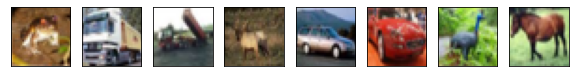

In [4]:
samples = x_train[:8, ...]
fig = plt.figure(figsize=(10,8))
for j in range(samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

In [15]:
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=x_train.shape[0])
train_ds = train_ds.batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#test_ds = test_ds.shuffle(buffer_size=x_train.shape[0])
test_ds = test_ds.batch(BATCH_SIZE)

#### Модель

In [85]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv_1=tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv_2=tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv_3=tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.conv_4=tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10)
        self.max_pooling = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
    
    def call(self, inp):

        out = self.conv_1(inp)
        out = self.max_pooling(out)
        out = self.conv_2(out)
        out = self.max_pooling(out)
        out = self.conv_3(out)
        out = self.max_pooling(out)
        out = self.conv_4(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out
    

In [86]:
model=Model()

In [87]:
LEARNING_RATE = 0.001
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
writer = tf.summary.create_file_writer('logs/adam')

In [88]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [89]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [90]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [91]:
EPOCHS = 5

for epoch in range(EPOCHS):

    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 1.4029608964920044, Accuracy: 49.0260009765625, Test Loss: 1.0660945177078247, Test Accuracy: 62.06999969482422
Epoch 2, Loss: 0.9330649375915527, Accuracy: 67.052001953125, Test Loss: 0.865827739238739, Test Accuracy: 69.81999969482422
Epoch 3, Loss: 0.7348751425743103, Accuracy: 74.3219985961914, Test Loss: 0.8021608591079712, Test Accuracy: 72.56999969482422
Epoch 4, Loss: 0.6004570722579956, Accuracy: 78.83200073242188, Test Loss: 0.7953850626945496, Test Accuracy: 72.93000030517578
Epoch 5, Loss: 0.4796532690525055, Accuracy: 83.01200103759766, Test Loss: 0.7732657790184021, Test Accuracy: 75.0199966430664


### TEST

In [94]:
def test_item(sample):
    
    logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(10,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample)
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {}'.format(class_names[ans]))

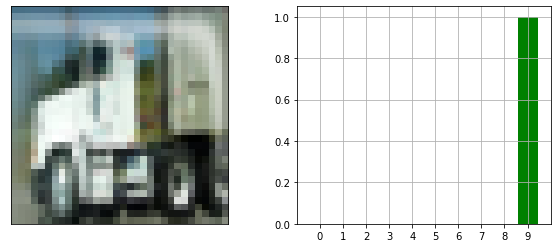

Predicted: truck
True Answer: 9 truck


In [102]:
import random
idx = random.randint(0, x_test.shape[0])
sample = x_test[idx, ...]
test_item(sample)

print(f'True Answer: {y_test[idx][0]} {class_names[y_test[idx][0]]}')